In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-05-24 16:02:28--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.134.16, 52.216.96.5, 52.216.113.229, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.134.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: 'jena_climate_2009_2016.csv.zip'

     0K .......... .......... .......... .......... ..........  0%  251K 53s
    50K .......... .......... .......... .......... ..........  0%  254K 52s
   100K .......... .......... .......... .......... ..........  1% 35.8M 35s
   150K .......... .......... .......... .......... ..........  1%  258K 39s
   200K .......... .......... .......... .......... ..........  1% 85.0M 31s
   250K .......... .......... .......... .......... ..........  2% 20.4M 26s
   300K .......... .......... .......... .......... ..........  2%  254K 29s
   350K .......... .......... .......... .......... 

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

In [17]:
temperature.shape

(420451,)

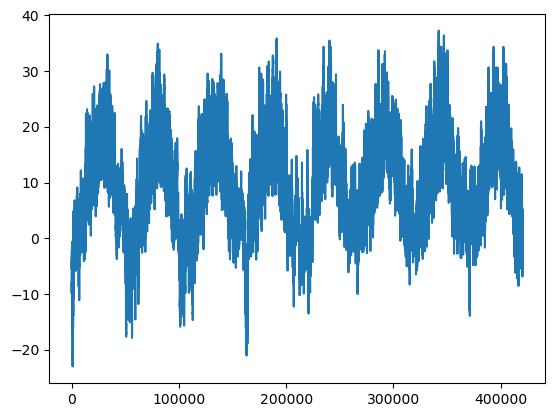

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
plt.show()

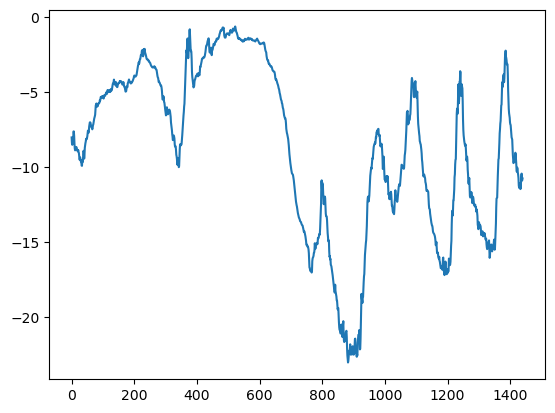

In [5]:
plt.plot(range(1440), temperature[:1440])
plt.show()

In [6]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [5]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]), i)

[0, 1, 2] 3 0
[1, 2, 3] 4 1
[2, 3, 4] 5 0
[3, 4, 5] 6 1
[4, 5, 6] 7 0


In [10]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1) + 1
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [19]:
raw_data.shape

(420451, 14)

In [21]:
val_dataset['targets']

TypeError: 'BatchDataset' object is not subscriptable

In [11]:
for samples, targets in train_dataset:
    print("샘플 크기:", samples.shape)
    print("타깃 크기:", targets.shape)
    break

샘플 크기: (256, 120, 14)
타깃 크기: (256,)


In [12]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"검증 MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"테스트 MAE: {evaluate_naive_method(test_dataset):.2f}")

검증 MAE: 2.45
테스트 MAE: 2.63


In [13]:
# 기본 딥러닝 모델을 사용한 예측
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 19s 22ms/step - loss: 12.4964 - mae: 2.7405 - val_loss: 14.3824 - val_mae: 3.0066
Epoch 2/10
819/819 [==============================] - 18s 22ms/step - loss: 9.0124 - mae: 2.3627 - val_loss: 10.4423 - val_mae: 2.5326
Epoch 3/10
819/819 [==============================] - 19s 23ms/step - loss: 8.3340 - mae: 2.2743 - val_loss: 11.2893 - val_mae: 2.6501
Epoch 4/10
819/819 [==============================] - 20s 24ms/step - loss: 7.8669 - mae: 2.2110 - val_loss: 11.1853 - val_mae: 2.6327
Epoch 5/10
819/819 [==============================] - 21s 26ms/step - loss: 7.5314 - mae: 2.1661 - val_loss: 11.2501 - val_mae: 2.6484
Epoch 6/10
819/819 [==============================] - 23s 28ms/step - loss: 7.2662 - mae: 2.1273 - val_loss: 10.7765 - val_mae: 2.5831
Epoch 7/10
819/819 [==============================] - 22s 27ms/step - loss: 7.0541 - mae: 2.0979 - val_loss: 12.1533 - val_mae: 2.7536
Epoch 8/10
819/819 [==============================] - 

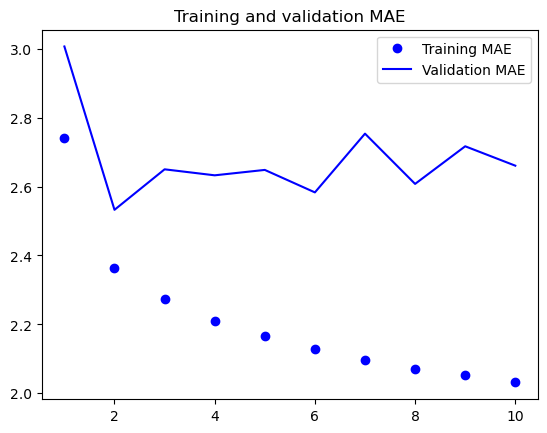

In [14]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

# 1D 합성공 모델 사용

In [15]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"테스트 MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 35s 41ms/step - loss: 20.3142 - mae: 3.5515 - val_loss: 17.0541 - val_mae: 3.2988
Epoch 2/10
819/819 [==============================] - 36s 44ms/step - loss: 14.9893 - mae: 3.0783 - val_loss: 17.8710 - val_mae: 3.3590
Epoch 3/10
819/819 [==============================] - 37s 46ms/step - loss: 13.5620 - mae: 2.9248 - val_loss: 14.0655 - val_mae: 2.9585
Epoch 4/10
819/819 [==============================] - 39s 47ms/step - loss: 12.5854 - mae: 2.8161 - val_loss: 14.9549 - val_mae: 3.0440
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 12.0288 - mae: 2.7522 - val_loss: 14.0047 - val_mae: 2.9569
Epoch 6/10
819/819 [==============================] - 39s 47ms/step - loss: 11.5632 - mae: 2.6987 - val_loss: 14.7915 - val_mae: 3.0372
Epoch 7/10
819/819 [==============================] - 41s 49ms/step - loss: 11.1955 - mae: 2.6528 - val_loss: 13.6557 - val_mae: 2.9021
Epoch 8/10
819/819 [============================